# Week 3 - Classification using Logistic Regression

Last week we learned how to speed up stochastic gradient descent.
This week we will learn how to apply it to classification problems.

Furthermore we'll use the implementation of SGD in scikit learn to apply the algorithm to multiple examples.
These examples will show the power and the limitations of SGD, and play nice into neural networks lecture of this week.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Recap Week 2

Last week we improved our optimizer for SGD by including a momentum hyper parameter, and introducing variable learning rates with RMSProp.
However, so far we have only applied it to linear regression problems. This week we will learn to apply it to logistic regression. We'll do this for both binary and multinomial classification.

In [2]:
#Recap: SGD with options for momentum and RMSProp
def lr_rmsprop(phi,t, eta, rho, mom, batch_size, epochs, weights_only=False, verbose=False):
    """
    Purpose:
        Stochastic Gradient Descent for a linear regression with momentum and RMSProp
    Inputs:
        phi        (n,k) matrix, design matrix
        t          (n,) vector, target variable
        eta        double, learning rate
        rho        double, RMSProp parameter
        mom        double, momentum parameter
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
        weights_only: boolean, if True then only the last, presumably best, weights are returned
        verbose:      boolean, if True then print cost and r squared at end of each epoch
    Output:
    if weights_only=True:
        weights    (k,) vector, last weights
    
    if weights_only=False:
        weights    (total_iters,k) matrix, weight values for each epoch
        gradients  (total_iters,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    n = t.shape[0]
    # intialize
    w = np.zeros(phi.shape[1])
    edma_dEdw = None    # exponentially weighted moving average of gradients
    edma_sq_dEdw = None # the exponentially weighted moving average of SQUARED gradients
        
    # calc iters per epoch given a batch size
    iters_per_epoch = (n-1)//batch_size + 1
    total_iters = epochs * iters_per_epoch
    
    # result arrays
    if not weights_only:
        weights = np.zeros((total_iters,phi.shape[1]))
        gradients = np.zeros((total_iters,phi.shape[1]))
        costs = np.zeros((total_iters))

    for epoch in range(int(epochs)):
        # shuffle the dataset
        shuffled_index = np.random.permutation(n)
        phi_s = phi[shuffled_index]
        t_s = t[shuffled_index]
        for i in range(iters_per_epoch):
            # set idx for result arrays
            idx = epoch * iters_per_epoch + i
            # get batch
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            t_b = t_s[i*batch_size:(i+1)*batch_size]
            
            # calc gradient
            y_b = phi_b@w        
            dEdw = -(t_b-y_b).T@phi_b
            
            # momentum update rule:
            if edma_dEdw is None:
                edma_dEdw = dEdw
            else:
                edma_dEdw = mom*edma_dEdw + (1-mom)*dEdw
                
            # rmsprop update rule:
            if isinstance(rho,float): # check if we want to do rmsprop
                if edma_sq_dEdw is None: # special case if there are no previous squared gradients
                    edma_sq_dEdw = dEdw**2
                else:
                    edma_sq_dEdw = rho*edma_sq_dEdw + (1-rho)*dEdw**2
                
                adj_eta = eta / np.sqrt(edma_sq_dEdw+1e-6)
            else:
                adj_eta = eta  
            
            # store
            if not weights_only:
                weights[idx,:] = w
                costs[idx] = 0.5*np.sum((t-phi@w)**2) #note this cost is based on the entire dataset
                gradients[idx,:] = dEdw

            # update parameters
            w = w - adj_eta*edma_dEdw
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
            
    if weights_only:
        return w
    else:
        return weights, gradients, costs

# Binary Classification

In last week's lecture you learned about logistic regression, where we use the sigmoid/softmax function to do binomial/multinomial classification. It was also already hinted that it forms the building block for the neural networks we'll be learning about in the coming weeks.

## Logistic Regression

To make predictions for a binary classification problem we turn to logistic regression. 

With logistic regression our target variable $\mathbf{t}$ is a vector of zeros and ones, indicating to which member 

With logistic regression two things change (see Section 4.3.2 of Bishop):

**The model:**

$\mathbf{y} = \sigma(\mathbf{a})$, where

$\sigma(a) = \frac{1}{1+e^{(-a)}}$ (the sigmoid function), and

$\mathbf{a} = \mathbf{\Phi w}$

**Illustration of the sigmoid**

![sigmoid activation function](https://www.cjbs.net/users/yihe/storage/mle/Sigmoid_Activation_Function_web.png)
*image credits: chris albon*



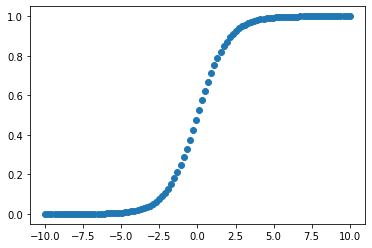

In [3]:
#Exercise: implement a sigmoid function
def sigmoid(a):
    """
    Sigmoid activation function
    """
    ### START CODE HERE ###
    s = 1/(1+np.exp(-a))
    ### END CODE HERE ###
    return s

#plot the sigmoid function (expect: S shape)
x = np.linspace(-10,10,100)
s = sigmoid(x)
plt.scatter(x,s)
plt.show()

**@Exercise: (4.12 in Bishop)** 

**A) Prove that $\frac{\partial \sigma(a)}{\partial a} = \sigma(a)(1-\sigma(a))$**

*@@@ START MARKDOWN HERE @@@*

$$\frac{\partial \sigma(a)}{\partial a} =\frac{\partial \frac{1}{1+e^{-a}}}{\partial a} = \frac{e^{-a}}{(1+e^{-a})^2}$$

add and subtract 1 in the numerator:

$$\frac{\partial \sigma(a)}{\partial a} = \frac{1+e^{-a}-1}{(1+e^{-a})^2}$$

split the fraction:

$$\frac{\partial \sigma(a)}{\partial a} = \frac{1+e^{-a}}{(1+e^{-a})^2} - \frac{1}{(1+e^{-a})^2}$$

refactor:

$$\frac{\partial \sigma(a)}{\partial a} = \frac{1}{(1+e^{-a})} - \left(\frac{1}{1+e^{-a}} \times \frac{1}{1+e^{-a}}\right)$$

$$\frac{\partial \sigma(a)}{\partial a} = \frac{1}{(1+e^{-a})} \left(1 - \frac{1}{1+e^{-a}}\right)$$

rewrite in terms of $\sigma(a)$

$$\frac{\partial \sigma(a)}{\partial a} = \sigma(a)(1-\sigma(a))$$

*@@@ END MARKDOWN HERE @@@*

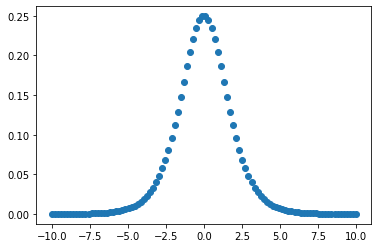

In [4]:
#Exercise: implement the derivative of the sigmoid function
def sigmoid_derivative(a):
    ### START CODE HERE ###
    s = sigmoid(a)
    derivative = s*(1-s)
    ### END CODE HERE ###
    return derivative

#check sigmoid gradient function (expect: bell shape)
x = np.linspace(-10,10,100)
s = sigmoid_derivative(x)
plt.scatter(x,s)
plt.show()

## Loss function for binary classification

From section 4.3.2 of Bishop you'll remember that:

For binary classification problems the likelihood function can be written as:

$$p(\mathbf{t|w}) = \prod_{n=}^N y_n^{t_n} \times (1-y_n)^{1-t_n}$$

We seek to maximize this likelihood function, which is equivalent to minimazing the negative (logarithm) which gives us the cross-entropy function:

$$E(\mathbf{w})=-\log{p(\mathbf{t|w})} = - \sum_{n=1}^N t_n \log y_n + (1-t_n)\log(1-y_n)$$

In [5]:
#Exercise: code the loss function for binary classification problems
def BCELoss(t,y):
    """
    Purpose:
        Binary Cross Entropy Loss
    Inputs:
        t   (n,) boolean vector, target variable 
        y   (n,) vector, prediction probability: between 0 and 1
    Output:
        E   double, binary cross entropy loss
    """
    ### START CODE HERE ###
    E = -np.sum(t*np.log(y) + (1-t)*np.log(1-y))
    return E
    ### START CODE HERE ###

**@Exercise: (4.13 in Bishop)** Derive the gradient $\frac{\partial E}{\partial \mathbf{w}}$ for the case of logistic regression (tip: use the chain rule)

*@@@ START MARKDOWN HERE @@@*

$$\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial \mathbf{y}}\times\frac{\partial \mathbf{y}}{\partial \mathbf{\sigma}}\times\frac{\partial \mathbf{\sigma}}{\partial \mathbf{a}}\times\frac{\partial \mathbf{a}}{\partial \mathbf{\Phi w}}\times\frac{\partial \mathbf{\Phi w}}{\partial \mathbf{w}}$$

$$\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial \mathbf{y}} \times 1 \times\frac{\partial \mathbf{\sigma}}{\partial \mathbf{a}}\times 1 \times\frac{\partial \mathbf{\Phi w}}{\partial \mathbf{w}}$$

$$\frac{\partial E}{\partial \mathbf{w}} = \frac{\partial E}{\partial \mathbf{y}} \times \frac{\partial \mathbf{\sigma}}{\partial \mathbf{a}}\times\frac{\partial \mathbf{\Phi w}}{\partial \mathbf{w}}$$

$$\frac{\partial E}{\partial \mathbf{w}} =  \left[ -\left(\mathbf{\frac{t}{y} - \frac{1-t}{1-y}} \right) \odot \mathbf{\sigma (1-\sigma)}\right]^T \Phi $$

where $\odot$ denotes the element-wise / hadamard / dot product

$$\frac{\partial E}{\partial \mathbf{w}} =  \left[ - \left(\mathbf{\frac{t}{y} - \frac{1-t}{1-y}} \right) \odot \mathbf{y (1-y)}\right]^T \Phi $$

$$\frac{\partial E}{\partial \mathbf{w}} =  -(\mathbf{t-y})^T \Phi $$


*@@@ END MARKDOWN HERE @@@*

## Implement Logistic Regression with gradient descent

Now we have all the building blocks required to adjust our SGD model of last week for binary classification

In [6]:
#Exercise: Implement binary logistic regression
# Feel free to copy and adjust the code from the recap
def bin_clf_rmsprop(phi,t, eta, rho, mom, batch_size, epochs, weights_only=False, verbose=False):
    """
    Purpose:
        Stochastic Gradient Descent for the binary logistic regression with momentum and RMSProp
    Inputs:
        phi        (n,k) matrix, design matrix
        t          (n,) vector, target variable
        eta        double, learning rate
        rho        double, RMSProp parameter
        mom        double, momentum parameter
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
        weights_only: boolean, if True then only the last, presumably best, weights are returned
        verbose:      boolean, if True then print cost and r squared at end of each epoch
    Output:
    if weights_only=True:
        weights    (k,) vector, last weights
    
    if weights_only=False:
        weights    (total_iters,k) matrix, weight values for each epoch
        gradients  (total_iters,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    ### START CODE HERE ###
    n = t.shape[0]
    # intialize
    w = np.zeros(phi.shape[1])
    edma_dEdw = None # exponentially weighted moving average of gradients
    edma_sq_dEdw = None # the exponentially weighted moving average of SQUARED gradients
        
    # calc iters per epoch given a batch size
    iters_per_epoch = (n-1)//batch_size + 1
    total_iters = epochs * iters_per_epoch
    
    # result arrays
    if not weights_only:
        weights = np.zeros((total_iters,phi.shape[1]))
        gradients = np.zeros((total_iters,phi.shape[1]))
        costs = np.zeros((total_iters))

    for epoch in range(int(epochs)):
        # shuffle the dataset
        shuffled_index = np.random.permutation(n)
        phi_s = phi[shuffled_index]
        t_s = t[shuffled_index]
        for i in range(iters_per_epoch):
            # set idx for result arrays
            idx = epoch * iters_per_epoch + i
            # get batch
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            t_b = t_s[i*batch_size:(i+1)*batch_size]
            
            # calc gradient
            y_b = sigmoid(phi_b@w)        
            dEdw = -(t_b-y_b).T@phi_b
            
            # momentum update rule:
            if edma_dEdw is None:
                edma_dEdw = dEdw
            else:
                edma_dEdw = mom*edma_dEdw + (1-mom)*dEdw
                
            # rmsprop update rule:
            if isinstance(rho,float): # check if we want to do rmsprop
                if edma_sq_dEdw is None: # special case if there are no previous squared gradients
                    edma_sq_dEdw = dEdw**2
                else:
                    edma_sq_dEdw = rho*edma_sq_dEdw + (1-rho)*dEdw**2
                
                adj_eta = eta / np.sqrt(edma_sq_dEdw+1e-6)
            else:
                adj_eta = eta  
            
            # store
            if not weights_only:
                weights[idx,:] = w
                costs[idx] = 0.5*np.sum((t-phi@w)**2) #note this cost is based on the entire dataset
                gradients[idx,:] = dEdw

            # update parameters
            w = w - adj_eta*edma_dEdw
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
    
    ### END CODE HERE ###
    
    if weights_only:
        return w
    else:
        return weights, gradients, costs

## Example: Toy Data

In [7]:
# function to create dataset
def create_toy_data(n, add_class=False):
    """
    Purpose:
        Creates toy data
    Inputs:
        n           even integer, size if the data
        add_class   boolean, if False(default) then only 2 classes are generated
                             if True, then 3 classes are generated
    Output:
    if add_class=False:
        x   (n,2) matrix, feature matrix
        t   (n,) vector of 0 and 1, target variable with 2 classes
    if add_class=True
        x   (1.5*n,2) matrix, feature matrix
        t   (1.5*n,) vector, target variable with 3 classes       
    """
    n=int(n)
    x0 = np.random.normal(size=n).reshape(-1, 2) - 1
    x1 = np.random.normal(size=n).reshape(-1, 2) + 1.

    if add_class:
        x2 = np.random.normal(size=n).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(n//2), np.ones(n//2), 2 + np.zeros(n//2)]).astype(np.int)
    
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(n//2), np.ones(n//2)]).astype(np.int)

In [8]:
# create mesh for plotting our predictions
n = 50  # size of the data
x_train, t_train = create_toy_data(n)
x1_mesh, x2_mesh = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T

feature = PolynomialFeatures(degree=1) # generates a feature matrix of all polynomial combinations of the features wuth degree 1
X_train = feature.fit_transform(x_train) # fit this feature structure to the data
X_mesh = feature.transform(x_mesh) #translate data to polynomial features

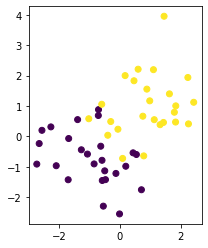

In [9]:
# plot 2 classes toy data
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train)
plt.gca().set_aspect('equal')
plt.show()

In [10]:
#Exercise: train a model, tune hyper parameters, explore predictions
### START CODE HERE ###
weights, dEdw, costs = bin_clf_rmsprop(X_train, t_train, 
                                         eta=0.5, 
                                         rho=False, 
                                         mom=0,
                                         batch_size=50,
                                         epochs=2000,
                                         weights_only=False,
                                         verbose=False)

### END CODE HERE ###


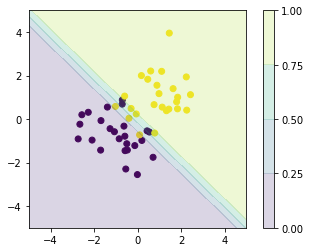

In [11]:
# Plot data (scatter), and predictions (mesh)

# make predictions on "test" set
w = weights[-1]
y_mesh = sigmoid(X_mesh@w)

#plot
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train)
plt.contourf(x1_mesh, x2_mesh, y_mesh.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Multiclass Classification

## Multiclass Logistic Regression

With multiple logistic regression our target variable $\mathbf{T}_{N \times K}$ with N observations, and K classes.
Each row contains K-1 zeros, and one 1, indicating to which class the observation belongs.

We have to a couple of changes to generalize our binary classification to this scenari:

1. Our loss function -- has to be generalized to K classes
2. Our model -- has to normalize the prediction probabilities to K classes

To be precise:

$$ E = -\sum_{n=1}^N \sum_{k=1}^K t_{n,k} \log (y_{n,k})$$

$$\mathbf{Y}_{N \times K} = \text{softmax}(\mathbf{A})$$

$$ \mathbf{A = \Phi W}$$

$$\text{softmax}(a_{n,i}) = \frac{\exp(a_{n,i})}{\sum_{j=1}^K \exp(a_{n,j})}$$

**Illustration of the softmax function:**

![softmax activation function](https://www.cjbs.net/users/yihe/storage/mle/Softmax_Activation_Function_web.png)

## Softmax

In [12]:
#Exercise: Implement the softmax, in a numerically robust way
#To make it robust: subtract the maximum per row
def softmax(A):
    """
    Applies the softmax per row, in a numerically robust way
    """
    ### START CODE HERE ###
    A = A.T # tranpose for ease of broadcasting
    Z = A - A.max(axis=0) # remove maximum per row (for stability)
    S = np.exp(Z) / np.exp(Z).sum(axis=0) # calc softmax

    return S.T
    ### END CODE HERE ###

## Loss function for multiclass regression

In [13]:
#Exercise: code the loss fucntion for multiclass logisitc regression
def CELoss(T,Y):
    """
    Implement the Cross Entropy Loss for multiclass classifcation
    
    Inputs:
        T      (n,k) matrix, target value
        Y      (n,k) matrix, predicted probabilities
    Output:
        loss   double, loss value
    """
    ### START CODE HERE ###
    loss = -np.sum(T * np.log(Y)) / T.shape[0]
    ### END CODE HERE ###
    return loss

**@Exercise:** (Re)write the gradient $\frac{\partial E}{\partial \mathbf{W}}$ for the case of softmax regression as a matrix multiplication . You can use equation 4.109 from Bishop as a starting point:

$$\nabla_{\mathbf{w_j}} E(\mathbf{w_1,\ldots,w_K}) = \sum_{n=1}^N (y_{nj}-t_{nj})\mathbf{\phi}_n$$

*@@@ START ANSWER HERE @@@*

$$\frac{\partial E}{\partial \mathbf{W}} = -\mathbf{\Phi^T(T-Y)}$$


*@@@ END ANSWER HERE @@@*

## Implement

In [14]:
#Exercise: Multiclass Logistic Regression
def mul_clf_rmsprop(phi,T,eta, rho, mom, batch_size, epochs, weights_only=False, verbose=False):
    """
    Purpose:
        Stochastic Gradient Descent for the multiclass logistic regression with momentum and RMSProp
    Inputs:
        phi        (n,m) matrix, design matrix
        T          (n,k) vector, target variable
        eta        double, learning rate
        rho        double, RMSProp parameter
        mom        double, momentum parameter
        batch_size integer, length of subset of data in one batch
        epochs     integer, number of epochs, that is the number of runs through the entire dataset
        weights_only: boolean, if True then only the last, presumably best, weights are returned
        verbose:      boolean, if True then print cost and r squared at end of each epoch
    Output:
    if weights_only=True:
        weights    (m,k) vector, last weights
    
    if weights_only=False:
        weights    (total_iters,m,k) matrix, weight values for each epoch
        gradients  (total_iters,m,k) matrix, gradient values for each epoch
        costs      (total_iters,) vector, loss values for each epoch
    """
    ### START CODE HERE ###
    n,k = T.shape
    m = phi.shape[1]
    # intialize
    W = np.zeros((m, k)) # <----- Each class gets its own weights
    edma_dEdw = None     # exponentially weighted moving average of gradients
    edma_sq_dEdw = None  # exponentially weighted moving average of SQUARED gradients
        
    # calc iters per epoch given a batch size
    iters_per_epoch = (n-1)//batch_size + 1
    total_iters = epochs * iters_per_epoch
    
    # result arrays
    if not weights_only:
        weights = np.zeros((total_iters,m,k))   # <---- Each class gets its own weights
        gradients = np.zeros((total_iters,m,k)) # <--- ...which in turn has its own derivative
        costs = np.zeros((total_iters))

    for epoch in range(int(epochs)):
        # shuffle the dataset
        shuffled_index = np.random.permutation(n)
        phi_s = phi[shuffled_index]
        T_s = T[shuffled_index]
        for i in range(iters_per_epoch):
            # set idx for result arrays
            idx = epoch * iters_per_epoch + i
            # get batch
            phi_b = phi_s[i*batch_size:(i+1)*batch_size,:]
            T_b = T_s[i*batch_size:(i+1)*batch_size]

            
            # calc gradient
            Y_b = softmax(phi_b@W)        
            dEdw = -phi_b.T@(T_b-Y_b) # <----- Gradient is now calculated slightly differently
            
            # momentum update rule:
            if edma_dEdw is None:
                edma_dEdw = dEdw
            else:
                edma_dEdw = mom*edma_dEdw + (1-mom)*dEdw
                
            # rmsprop update rule:
            if isinstance(rho,float): # check if we want to do rmsprop
                if edma_sq_dEdw is None: # special case if there are no previous squared gradients
                    edma_sq_dEdw = dEdw**2
                else:
                    edma_sq_dEdw = rho*edma_sq_dEdw + (1-rho)*dEdw**2
                
                adj_eta = eta / np.sqrt(edma_sq_dEdw+1e-6)
            else:
                adj_eta = eta  
            
            # store
            if not weights_only:
                weights[idx,:,:] = W
                costs[idx] = CELoss(T, softmax(phi@W)) #note this cost is based on the entire dataset
                gradients[idx,:,:] = dEdw

            # update parameters
            W = W - adj_eta*edma_dEdw
        
        # print
        if verbose:
            r2 = r2_score(t,y)
            print(f'epoch: {epoch}: E:{E:.2f}, R2:{r2:.2f}')    
    

    ### END CODE HERE ###
            
    if weights_only:
        return W
    else:
        return weights, gradients, costs

## Example: Toy Data

In [15]:
# make a toy dataset
x_train, t_train = create_toy_data(n,add_class=True)

# add features
feature = PolynomialFeatures(1)
X_train = feature.fit_transform(x_train)

# reformat t_train to a matrix
T_train = np.zeros((t_train.shape[0],3))
for c in range(3):
    T_train[t_train==c,c] = 1

# make a mesh grid for plotting
x1_mesh, x2_mesh = np.meshgrid(np.linspace(-5, 8, 100), np.linspace(-5, 8, 100))
x_mesh = np.array([x1_mesh, x2_mesh]).reshape(2, -1).T
X_mesh = feature.transform(x_mesh)

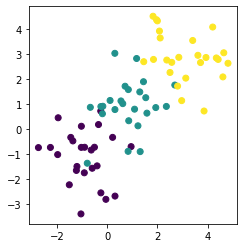

In [16]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [17]:
#Exercise: train a model, tune hyper parameters, explore predictions

### START CODE HERE ###
weights, gradients, costs = mul_clf_rmsprop(phi=X_train,
                                            T=T_train,
                                            eta=0.1,
                                            rho=0.9,
                                            mom=0,
                                            batch_size=X_train.shape[0],
                                            epochs=int(1e5))
### END CODE HERE ###

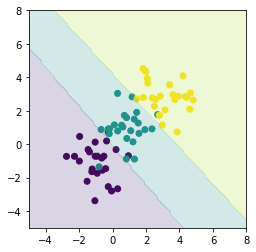

In [18]:
# predict
W = weights[-1]
Y_pred = softmax(X_mesh@W)

# reformat
y_pred = Y_pred.argmax(axis=1)

# plot
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train)
plt.contourf(x1_mesh, x2_mesh, y_pred.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# SGD with Regularization

You have already learned about regularization in week 1 of this course (Chapter 3.1.4). "Regularization is any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error" (Goodfellow 2016)

The most well known technique for regularization is *weight decay*, also known for least squares as "regularized least squares". Simply put it adds an additional term to the error/loss function which is increases as the (absolute) value of the weights increase. As a result weights can only receive larger (absolute) values if they sufficiently reduce the error on the data.

$$E(\mathbf{W}) = E_D(\mathbf{W}) + \lambda E_W(\mathbf{W})$$

*Note: Bishop uses $\lambda$ as the regularization parameter, scikit-learn uses $\alpha$.*

As described in Bishop, there are different implementations for $E_W$, today we will focus on:

$$E_W(\mathbf{W}) = \frac{1}{2} \sum_{m=1}^M\sum_{k=1}^K w_{m,k}^2$$



## Derivation

**@Exercise:**

* Show how the regularization procedure introduced above changes the gradient $\frac{\partial E}{\partial \mathbf{W}}$, 
* Show how it changes the update step in SGD
* Describe how the update step is changed in your own words

*@@@ START ANSWER HERE @@@*

$$\frac{\partial E}{\partial \mathbf{W}} = \frac{\partial E_D}{\partial \mathbf{W}} + \lambda \mathbf{W}$$

$$\mathbf{W}_{t+1} = \mathbf{W_t} - \eta (\frac{\partial E_D}{\partial \mathbf{W_t}} + \lambda \mathbf{W_t}) $$

$$\mathbf{W}_{t+1} = \mathbf{W_t} (1-\eta \lambda) - \eta \frac{\partial E_D}{\partial \mathbf{W_t}} $$

Weight decay sets the old weights a bit closer to zero at each update step because $0<(1-\eta\lambda)<1$


*@@@ END ANSWER HERE @@@*

# Examples

Above we implemented logistic regression with SGD. We also looked at how we can apply weight decay with SGD. In practice you'll most likely use an implementation such as the one in *scikit-learn*. Below you are tasked with applying logistic regression with regularization to some datasets. 

These exercises have multiple goals:

0. Explore the strenghts and limitations of linear models
1. Refresh your knowledge from Data Science Methods on:
    * Regularization
    * Cross-Validation
    * Scikit-learn
2. Learn how images can be turned into inputs for our models


Datasets:

* MNIST: a classical example of multiclass regression on visual data.
    * Input: Pixel representation of handwritten digits
    * Output: 0,1,2,...,9
* XOR: a classsical example of how logistic regression **cannot** learn some simple relationships
    * Input: two dummy variables
    * Output: 0 if the two dummy variables are the same, 1 if they are different (exclusive-or-relationship)
    
    
Feel free to play around with the data and models below

## Example 1: MNIST Digit Recognition

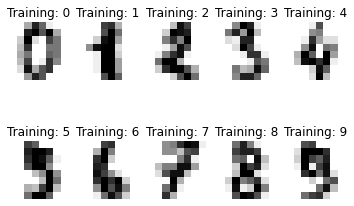

In [19]:
# load data from the scikit-learn library
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, that are reshaped in 64x1 array.
# Let's have a look at the first 4 images, stored in the `data` attribute of the dataset. 

images_and_labels = list(zip(digits.data, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [20]:
X = digits.data
t = digits.target

# train test split of the data
X_train, X_test, t_train, t_test = train_test_split(X,t,random_state=42)

In [21]:
# Calculate logistic model with regularization
from sklearn.linear_model import SGDClassifier

alpha = 0.000001  #try later gcv.best_params_['alpha']
clf = SGDClassifier(loss='log', alpha = alpha, max_iter=100, tol=0.0001)
clf.fit(X_train, t_train)


SGDClassifier(alpha=1e-06, loss='log', max_iter=100, tol=0.0001)

In [22]:
# Confusion matrix
from sklearn import metrics

y_test = clf.predict(X_test)
cm = metrics.confusion_matrix(t_test, y_test)
print('Confusion matrix:\n', cm)

# Prediction example
print('\nExample of predicted values:\n', y_test[0:20])
print('\nwhile the true values are:\n', t_test[0:20])

Confusion matrix:
 [[42  0  1  0  0  0  0  0  0  0]
 [ 0 34  2  0  1  0  0  0  0  0]
 [ 0  0 36  2  0  0  0  0  0  0]
 [ 0  0  1 45  0  0  0  0  0  0]
 [ 0  0  0  0 54  0  1  0  0  0]
 [ 0  0  1  0  0 57  1  0  0  0]
 [ 0  0  0  0  0  1 44  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  2  1  2  0  1  0  0 32  0]
 [ 0  0  0  3  1  1  0  0  1 42]]

Example of predicted values:
 [6 9 3 7 2 2 5 2 5 3 1 4 4 0 4 2 3 7 8 8]

while the true values are:
 [6 9 3 7 2 1 5 2 5 2 1 9 4 0 4 2 3 7 8 8]


Test score:0.967


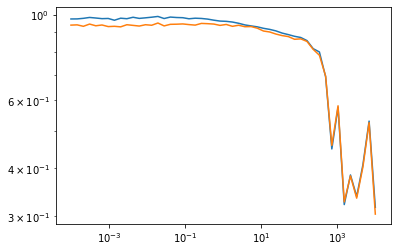

In [23]:
# Create the best possible model using only the train set, and then evaluate performance on the test set
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-4,4)}
gcv = GridSearchCV(SGDClassifier(loss='log',max_iter=100, tol=0.0001),param_grid=param_grid,cv=3,return_train_score=True)
gcv.fit(X_train,t_train)

# example validation plot
res = pd.DataFrame(gcv.cv_results_)
plt.plot(res.param_alpha,res.mean_train_score)
plt.plot(res.param_alpha,res.mean_test_score)
plt.yscale('log')
plt.xscale('log')

# example final test score
test_score = gcv.score(X_test,t_test)
print(f'Test score:{test_score:.3f}')

In [24]:
print('Best regularizatiuion parameter:', gcv.best_params_['alpha'])
# Use this parameter to train your model

Best regularizatiuion parameter: 0.019306977288832496


## Example 2: XOR Relationship

Now you've seen that with linear models we can estimate models for seemingly difficult problems with reasonable accuracy. Below we will show an important counter example to the power of linear models: the exclusive-OR relationship (XOR).

data:

```
x1 XOR x2 --> y

0  XOR  0 --> 0

1  XOR  1 --> 0

0  XOR  1 --> 1

1  XOR  0 --> 1
```

We should hope that a we can model such a simple relationship perfectly, however it turns out it is impossible with a linear model.

In [25]:
# Exercise: Estimate a linear model to train an XOR relationship (no cross validation needed)
X = np.array([[0,1],[1,0],[0,0],[1,1]])
t = np.array([1,1,0,0])

### START CODE HERE ###
clf = SGDClassifier(loss='log',max_iter=300,tol=0.0001)
clf.fit(X,t)
print('Score:', clf.score(X,t))
print('\nPredicted values are', clf.predict(X))
### END CODE HERE ###

Score: 0.5

Predicted values are [0 0 0 0]


**@Exercise:**

Argue why a linear model cannot learn an XOR relationship.
You can do this intuitively/visually/mathematically.

*@@@ START MARKDOWN HERE @@@*

[See both mathematical and intuitive answers here](https://www.quora.com/Why-cant-the-XOR-problem-be-solved-by-a-one-layer-perceptron)

*@@@ END MARKDOWN HERE @@@*

# Recap

Today we learned:

* How to do (multiclass) logistic regression
* How we can apply weight decay with SGD
* How linear classification models can:
       * Do well on seemingly difficult tasks (images)
       * Do poorly on seemingly trivial tasks (XOR)
       
Furthermore you refreshed / familiarized yourself with:

* Scikit-learn
* Cross Validation
* Image analysis